In [32]:
import sys, os
project_root = "/home/shuol/final-project-group"
if project_root not in sys.path:
    sys.path.append(project_root)
import numpy as np
import matplotlib.pyplot as plt
from time import time

from src.Problems.lasso import LassoProblem
from src.Problems.total_var import TotalVariationProblem
from src.Problems.huber_comp import HuberCompositeProblem
from src.Problems.quadratic import QuadraticProblem,BoxQuadraticProblem
from src.Problems.logistic import LogisticProblem, LogisticBoxProblem
from src.Problems.comirror_box import CoMirrorBoxProblem
from src.Problems.constrained import PolytopeQuadraticProblem

from src.Method.prox_gradient import ProxGradient
from src.Method.fista import FISTA
from src.Method.sfista import SmoothedFISTA
from src.Method.fdpg import FDPG
from src.Method.adlpmm import ADLPMM
from src.Method.prox_subgradient import ProxSubgradient
from src.Method.comd import CoMirrorDescent

from src.util.proj import proj_box

In [66]:
def projected_step(solver, problem, lower, upper):
    """
    Performs one solver step and projects onto [lower, upper].
    Used for PG, PSG which do NOT enforce constraints internally.
    """
    solver.step()
    solver.x = proj_box(solver.x, lower, upper) #use projextion implemented

def run_solver(solver, problem, K, use_projection=False, lower=None, upper=None):
    """run solver in K iterations, store the objective and time used for plot.
    """
    obj = []
    t0 = time()
    for _ in range(K):
        if use_projection:
            projected_step(solver, problem, lower, upper)
        else:
            solver.step()
        obj.append(problem.f(solver.x))
    return np.array(obj), time() - t0

### Case 1: Quadratic Problem with Box Constraint

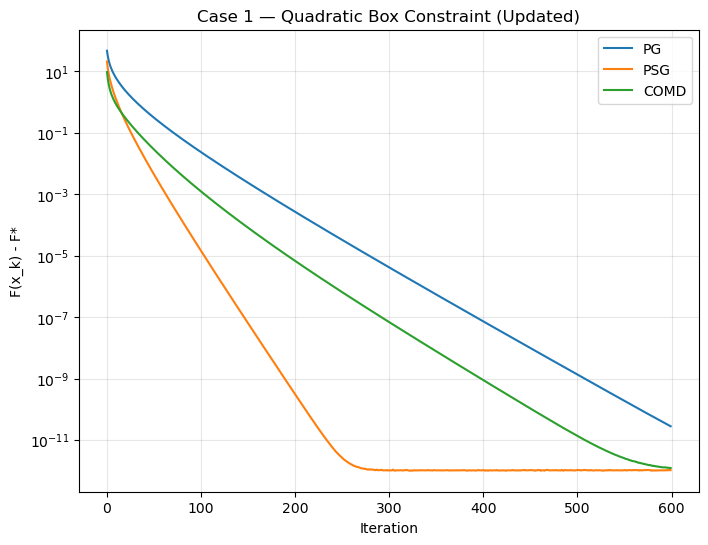

PG: 0.018773317337036133
PSG : 0.02176189422607422
COMD : 0.02477550506591797


In [3]:
np.random.seed(0)
n = 80
K = 600

lower = np.zeros(n)
upper = np.ones(n)

n = 80
eigvals = np.logspace(0, 1.5, n)  
Q = np.diag(eigvals)

x_star = np.random.rand(n) * 0.8 + 0.1
b = -Q @ x_star
problem = BoxQuadraticProblem(Q, b, lower, upper)

L = eigvals.max()
pg  = ProxGradient(problem, x0=np.zeros(n), alpha=0.6 / L)
psg = ProxSubgradient(problem, x0=np.zeros(n), step_rule=lambda k: 0.05 / np.sqrt(k+1))
comd = CoMirrorDescent(problem,x0=np.ones(n) * 0.5,step_size=0.02)

history = {}
history["PG"], t_pg   = run_solver(pg,  problem, K, True, lower, upper)
history["PSG"], t_psg  = run_solver(psg, problem, K, True, lower, upper)
history["COMD"], t_comd = run_solver(comd, problem, K, False)

#plot
plt.figure(figsize=(8, 6))
F_min = min(v.min() for v in history.values())
for name, vals in history.items():
    plt.plot(vals - F_min + 1e-12, label=name)

plt.yscale("log")
plt.title("Case 1 — Quadratic Box Constraint (Updated)")
plt.xlabel("Iteration")
plt.ylabel("F(x_k) - F*")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("PG:", t_pg)
print("PSG :", t_psg)
print("COMD :", t_comd)

### Case 2: Logistic Regression with Box Constraint

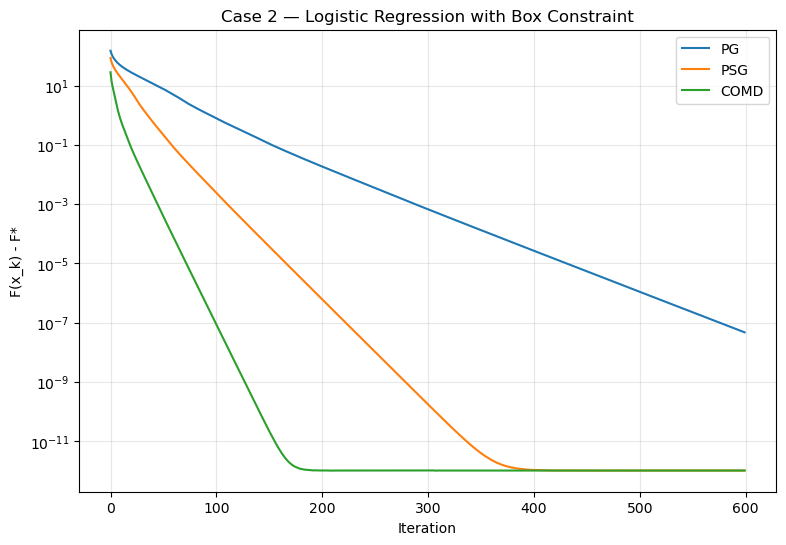

PG: 0.10000395774841309
PSG: 0.05446052551269531
COMD: 0.09242630004882812


In [31]:
np.random.seed(0)
m = 400
n = 80
K = 600

lower = 0 #box lower and upper
upper = 1
A = np.random.randn(m, n)
x_true = np.random.rand(n)
y = np.sign(A @ x_true + 0.2*np.random.randn(m))
y[y == 0] = 1

lam = 0.1
problem = LogisticBoxProblem(A, y, lam=lam, lower=lower, upper=upper)

# Lipschitz estimate
L = np.linalg.norm(A, 2)**2 / 4 + lam
alpha = 0.8 / (L + 1e-12)

pg = ProxGradient(problem, x0=np.zeros(n), alpha=alpha)
psg = ProxSubgradient(problem,x0=np.zeros(n),step_rule=lambda k: 0.01 / np.sqrt(k+1))
comd = CoMirrorDescent(problem,x0=np.ones(n) * 0.5,step_size=0.02)

history = {}
history["PG"], t_pg = run_solver(pg,    problem, K, use_projection=True,  lower=lower, upper=upper)
history["PSG"],t_psg = run_solver(psg,   problem, K, use_projection=True,  lower=lower, upper=upper)
history["COMD"], t_comd = run_solver(comd,  problem, K, use_projection=False)

# Plot
plt.figure(figsize=(9, 6))
F_min = min(v.min() for v in history.values())

for name, vals in history.items():
    plt.plot(vals - F_min + 1e-12, label=name)

plt.yscale("log")
plt.title("Case 2 — Logistic Regression with Box Constraint")
plt.xlabel("Iteration")
plt.ylabel("F(x_k) - F*")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("PG:", t_pg)
print("PSG:", t_psg)
print("COMD:", t_comd)

### Case 3: Quadratic Problem with many constraints

Only CoMirrorDescent can handle this directly via constraint oracles.
Prox-gradient / FISTA / PSG would need an explicit projection onto the polytope {x : Gx <= h}, which we do not implement here.

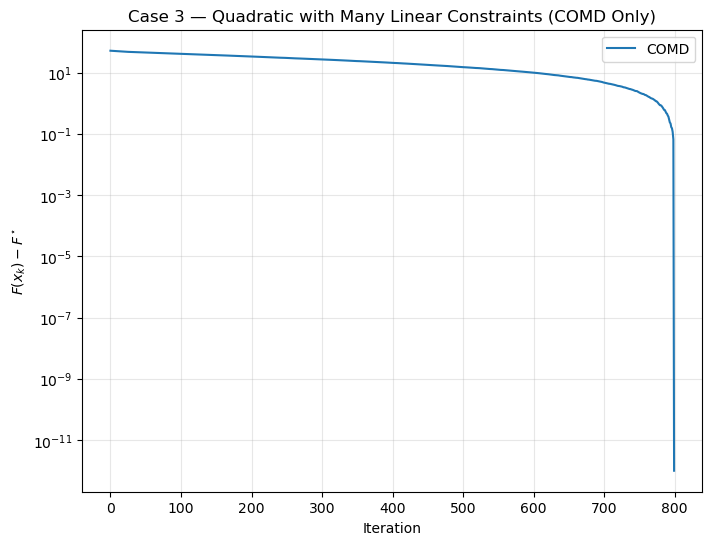

COMD runtime: 0.0496 s


In [65]:
np.random.seed(0)
n = 80   
m = 200 
p = 300 # number of linear constraints
K = 800

A = np.random.randn(m, n) / np.sqrt(n)
# choose a ground-truth feasible point
x_true = np.random.randn(n)
b = A @ x_true

# random constraints Gx <= h, shifted so x_true is strictly feasible
G = np.random.randn(p, n) / np.sqrt(n)
margin = 0.5
h = G @ x_true + margin   # so G x_true <= h - margin

problem = PolytopeQuadraticProblem(A, b, G, h)
x0 = np.zeros(n)

comd = CoMirrorDescent(problem, x0=x0, step_size=0.02)
history_comd, t_comd = run_solver(comd, problem, K, use_projection=False)
F_star = history_comd.min()

#plot
plt.figure(figsize=(8, 6))
plt.plot(history_comd - F_star + 1e-12, label="COMD")

plt.yscale("log")
plt.title("Case 3 — Quadratic with Many Linear Constraints (COMD Only)")
plt.xlabel("Iteration")
plt.ylabel(r"$F(x_k) - F^\star$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"COMD runtime: {t_comd:.4f} s")